In [1]:
import cv2
import os
from PIL import Image
from scipy import misc

import tensorflow.keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

# DATA Preprocessing

In [2]:
#Data Preprocessing

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img

def create_dataset(img_folder):
   
    img_data_array=[]
    class_name=[]
    
    for file in os.listdir(img_folder):
        
        image_path = os.path.join(img_folder, file)
        image = load_img(image_path, 'rb')
        image = img_to_array(image)
        
        if image.shape[2] == 3:
            image = image.mean(2)
        img_data_array.append(image)
        class_name.append(file[0])
        
    return np.array(img_data_array), np.array(class_name)

def normalization(image):
    image = (image - image.min()) / (image.max() - image.min())
    return image


training_path = "./01_finger_training"
test_path = './01_finger_test'

train_data, train_label = create_dataset(training_path)
test_data, _ = create_dataset(test_path)
test_label = np.zeros(test_data.shape[0])

train_data = normalization(train_data)
test_data = normalization(test_data)

In [3]:
print('Shape of Train images :',train_data.shape)
print('Shape of Train labels : ', train_label.shape)
print('\nShape of Test images : ', test_data.shape)
print("Shape of Test labels : ",test_label.shape)

Shape of Train images : (80, 144, 144)
Shape of Train labels :  (80,)

Shape of Test images :  (80, 144, 144)
Shape of Test labels :  (80,)


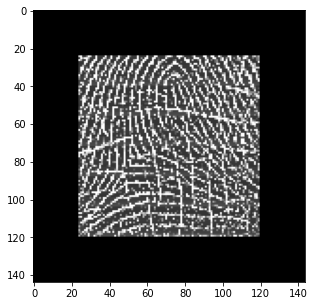

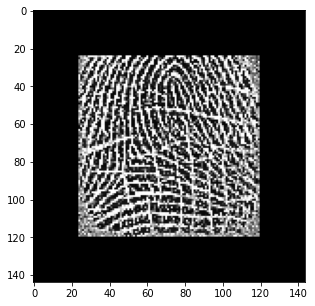

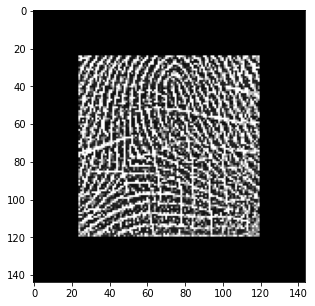

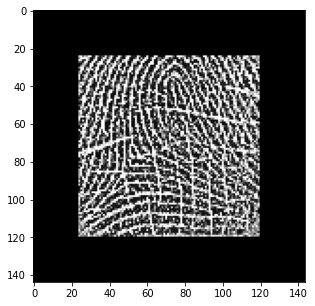

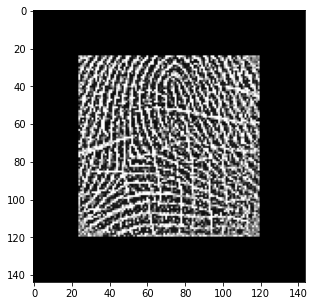

Train labels :  ['1' '1' '1' '1' '1' '1' '1' '1' '1' '1' '2' '2' '2' '2' '2' '2' '2' '2'
 '2' '2' '3' '3' '3' '3' '3' '3' '3' '3' '3' '3' '4' '4' '4' '4' '4' '4'
 '4' '4' '4' '4' '5' '5' '5' '5' '5' '5' '5' '5' '5' '5' '6' '6' '6' '6'
 '6' '6' '6' '6' '6' '6' '7' '7' '7' '7' '7' '7' '7' '7' '7' '7' '8' '8'
 '8' '8' '8' '8' '8' '8' '8' '8']
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [4]:
for i in range(5):
    plt.figure(figsize=[5, 5])
    curr_img = train_data[i]
    plt.imshow(curr_img, cmap='gray')
    plt.show()


print('Train labels : ',train_label)
print(train_data[1])

In [5]:
train_data = train_data.reshape(-1, 144, 144, 1)
test_data = test_data.reshape(-1, 144, 144, 1)

print(train_data.shape)
print(train_data.dtype)

(80, 144, 144, 1)
float32


In [6]:
from sklearn.model_selection import train_test_split

train_data,valid_data,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.1,
                                                             random_state=13)

print(train_data.shape)
print(valid_data.shape)

(72, 144, 144, 1)
(8, 144, 144, 1)


# Model

In [7]:
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense


batch_size = 128
#epochs = 200
epochs = 10
inChannel = 1
x, y = 144, 144
input_img = Input(shape = (x, y, inChannel))

In [8]:
def autoencoder(input_img):
    #encoder
    #input = 144 x 144 x 1 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)

    #decoder
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 128
    up1 = UpSampling2D((2,2))(conv4) # 14 x 14 x 128
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 64
    up2 = UpSampling2D((2,2))(conv5) # 28 x 28 x 64
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [9]:
autoencoder = Model(input_img, autoencoder(input_img))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(learning_rate=0.1))
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 144, 144, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 144, 144, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 36, 36, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 128)       147584

# Train Model

In [ ]:
autoencoder_train = autoencoder.fit(train_data, train_ground, batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_data, valid_ground))

Epoch 1/10
1/1 [==============================] - 15s 15s/step - loss: 0.2028 - val_loss: 0.1591
Epoch 2/10
1/1 [==============================] - 14s 14s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 3/10
1/1 [==============================] - 14s 14s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 4/10
1/1 [==============================] - 14s 14s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 5/10
1/1 [==============================] - 13s 13s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 6/10
1/1 [==============================] - 14s 14s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 7/10
1/1 [==============================] - 15s 15s/step - loss: 0.1645 - val_loss: 0.1591
Epoch 8/10
